# The Lending Club: Finding an Optimal Investment Portfolio
IFTE0002 Coursework, Group F  
Iman Zafar, Rickey Chen, Ariq Zidane, Aadhira Chavan, Gabriella Larissa, Owen Babbington-Ellis, Kane Basu

## Introduction

To include: 
- what is the lending club (peer-to-peer lending platform)
- aim of the project (2 investment strategies, comparison across strategies and comparison with a random strategy)
- dataset being used
- outline of remaining notebook (i.e., what the remaining sections will include)

## Data Exploration

<div style="line-height: 1.6;">
The lending club dataset provides loan-level data about loan agreements that took place on the platform. The data includes information about the borrower's profile, the loan's terms, and the performance of the loan. As part of our data exploration, we dive into each of the features provided in the dataset to better understand the properties of the features and how they interact with each other.
</div>
<br>
<div style="line-height: 1.6;">
A general examination of the completeness of the dataset revealed that only the 'emp_length' column had missing values, with 6.4% of the values being null. As this is not a significant proportion, we don't expect this to impact model training.
</div>
<br>
<div style="line-height: 1.6;">
As the aim of our project is creating optimal investment strategies based on loan return and default, we begin by examining the distributions of our target variables. We use the 'loan_status' feature for the strategy based on default and 'ret_INTa' for the strategy based on return. The feature used for return here is treated as a proxy for the purpose of data exploration, and a custom definition of return is defined at a later stage.
</div>

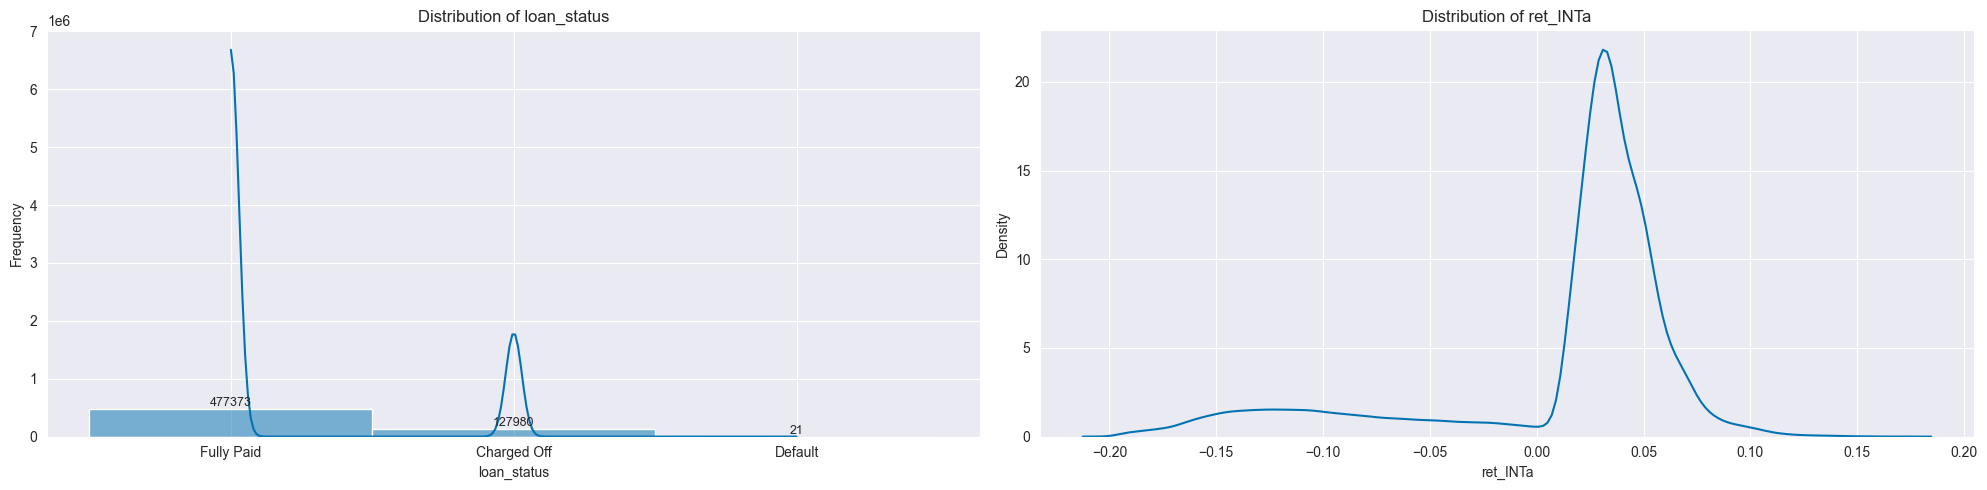

In [15]:
fig, axs = plt.subplots(1, 2, figsize=(20, 5))
plt.sca(axs[0])
eda.plot_distribution("loan_status", subplot=True)
plt.sca(axs[1])
eda.plot_distribution("ret_INTa", subplot=True)
plt.tight_layout()
plt.show()


<div style="line-height: 1.6;">
As seen in the plot above, the 'loan_status' feature has significant class imbalance. Since we are looking to predict default, which has a count of only 21 among the 605374 loans, predicting with this feature may lead to poor model performance. This is because the model will not have enough instances of default to learn from and may only learn to predict the majority class. In order to improve this issue, we create our target feature to consider both 'Default' and 'Charged Off' as instances of default. We expect this to have no impact conceptually since a loan is written off as 'Charged Off' when it has become unlikely for the loan to be recovered, indicating a failure to repay.
</div>
<br>
<div style="line-height: 1.6;">
The distribution of return provides some positive implications as most regression models assume 'normally distributed' errors. A gaussian-like (roughly bell-shaped, as above) distribution is also useful as there's a lower chance of having issues of heteroskedasticity (changing variance across the ranges of predictions).
</div>

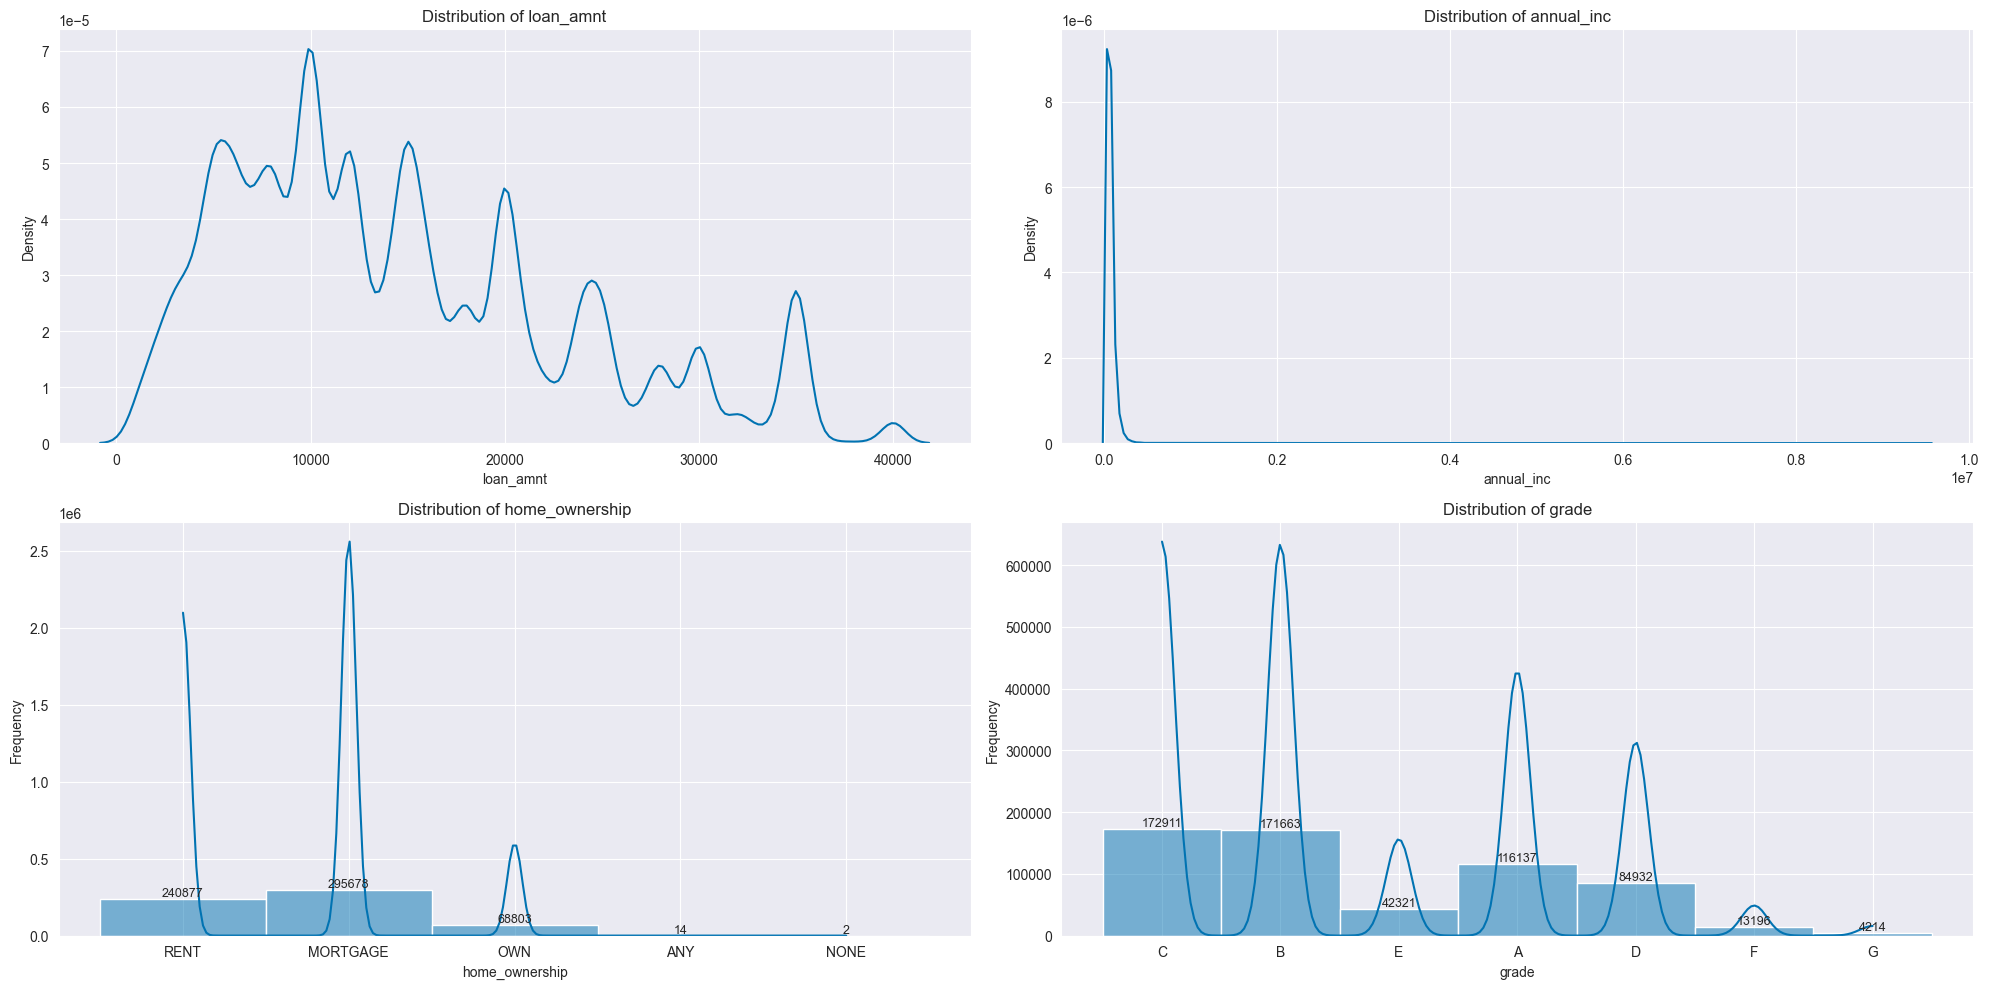

In [18]:
fig, axs = plt.subplots(2, 2, figsize=(20, 10))
plt.sca(axs[0, 0])
eda.plot_distribution("loan_amnt", subplot=True)
plt.sca(axs[0, 1])
eda.plot_distribution("annual_inc", subplot=True)
plt.sca(axs[1, 0])
eda.plot_distribution("home_ownership", subplot=True)
plt.sca(axs[1, 1])
eda.plot_distribution("grade", subplot=True)
plt.tight_layout()
plt.show()

<div style="line-height: 1.6;">
Looking at the above distributions of some of the explanatory features, we see that 'loan_amnt' shows a multi-modal distribution, meaning it has more than one peak, specficially around 10k, 15k, 20k etc, which tend to be typical loan values. 'annual_inc' has an extreme right-skewed distribution, also aligned with expectations of incomes across a representative dataset. Carrying on from behaviour expected from majority low or medium-income individuals, we see higher occurrences of renting and mortgages and a low occurence of ownership. 'grade' sees majority instances across grades A - C, showing fewer instances of low-grade loans.
</div>
<br>
<div style="line-height: 1.6;">
Before building our models, we also examine the relationship between some of our key features to ensure conceptual soundness and analyse what we may expect of feature importances.
</div>

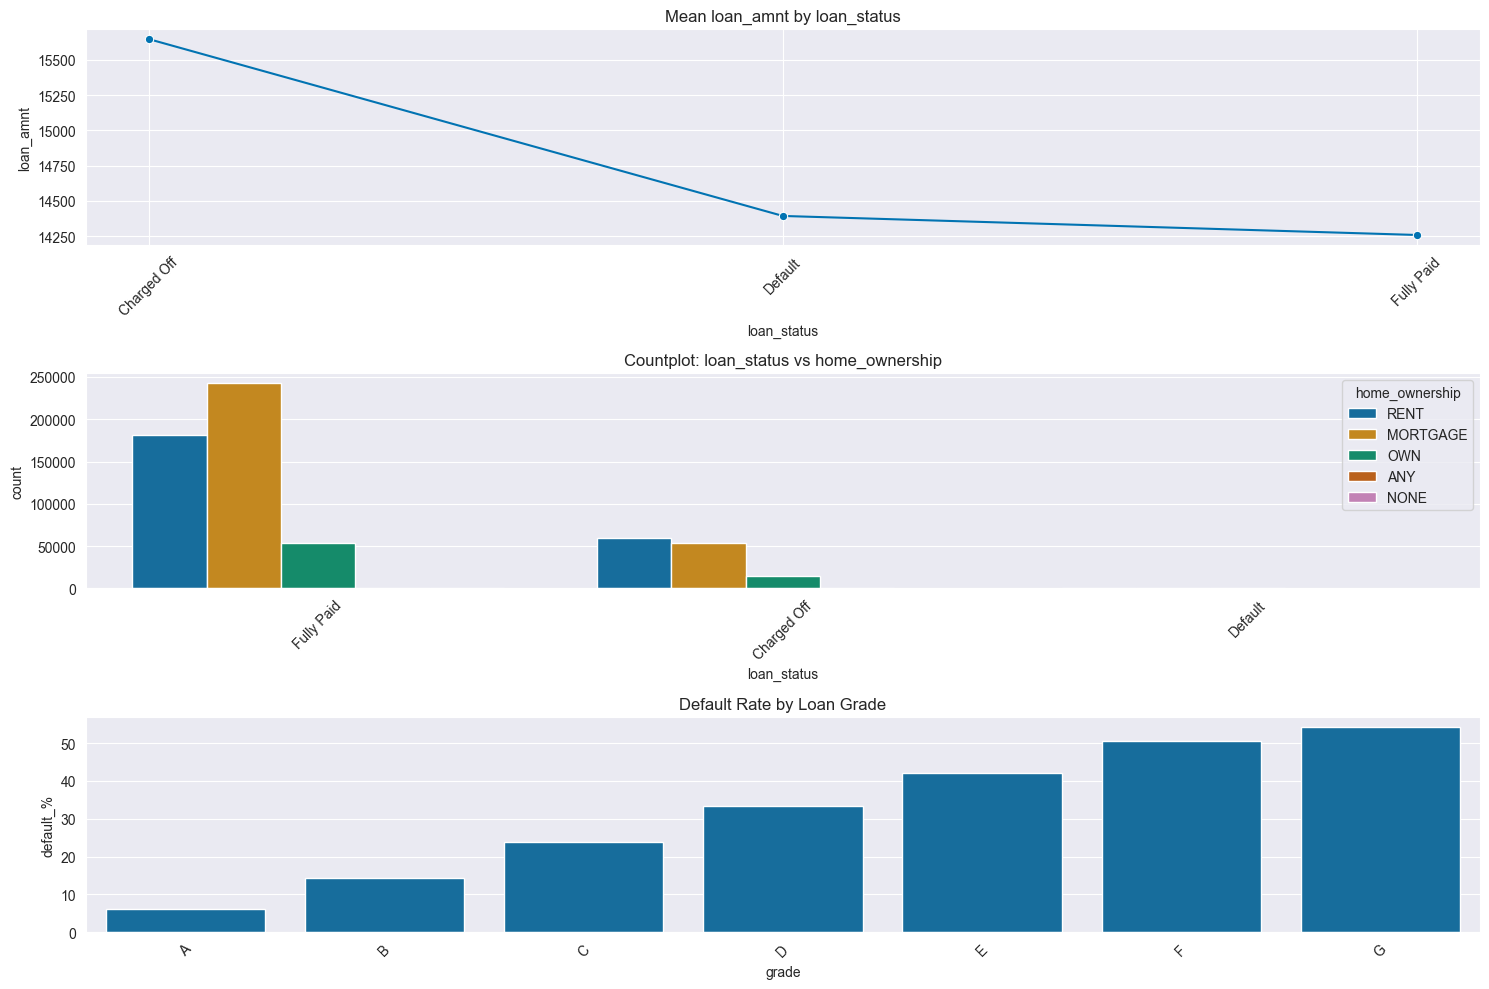

In [31]:
fig, axs = plt.subplots(3, 1, figsize=(15, 10))
plt.sca(axs[0])
eda.plot_line_discrete_continuous(x_discrete="loan_status", y_continuous="loan_amnt", subplot=True)
plt.sca(axs[1])
eda.plot_relationship_discrete("loan_status", "home_ownership", subplot=True)
plt.sca(axs[2]) 
eda_grade.bar_plot_by_index("default_%", title="Default Rate by Loan Grade", subplot=True)
plt.tight_layout()
plt.show()

<div style="line-height: 1.6;">
As expected, a lower loan amount show more occurences of full payment, with loans issues at high amounts being mostly charged off. We also see that loans that were fully paid had a greater proportion of mortgage holders than those that were charged off. In the last plot, we see that loans with a better grade had a lower percentage of default. All these findings are in line with our expectations of general customer behaviour.
</div>

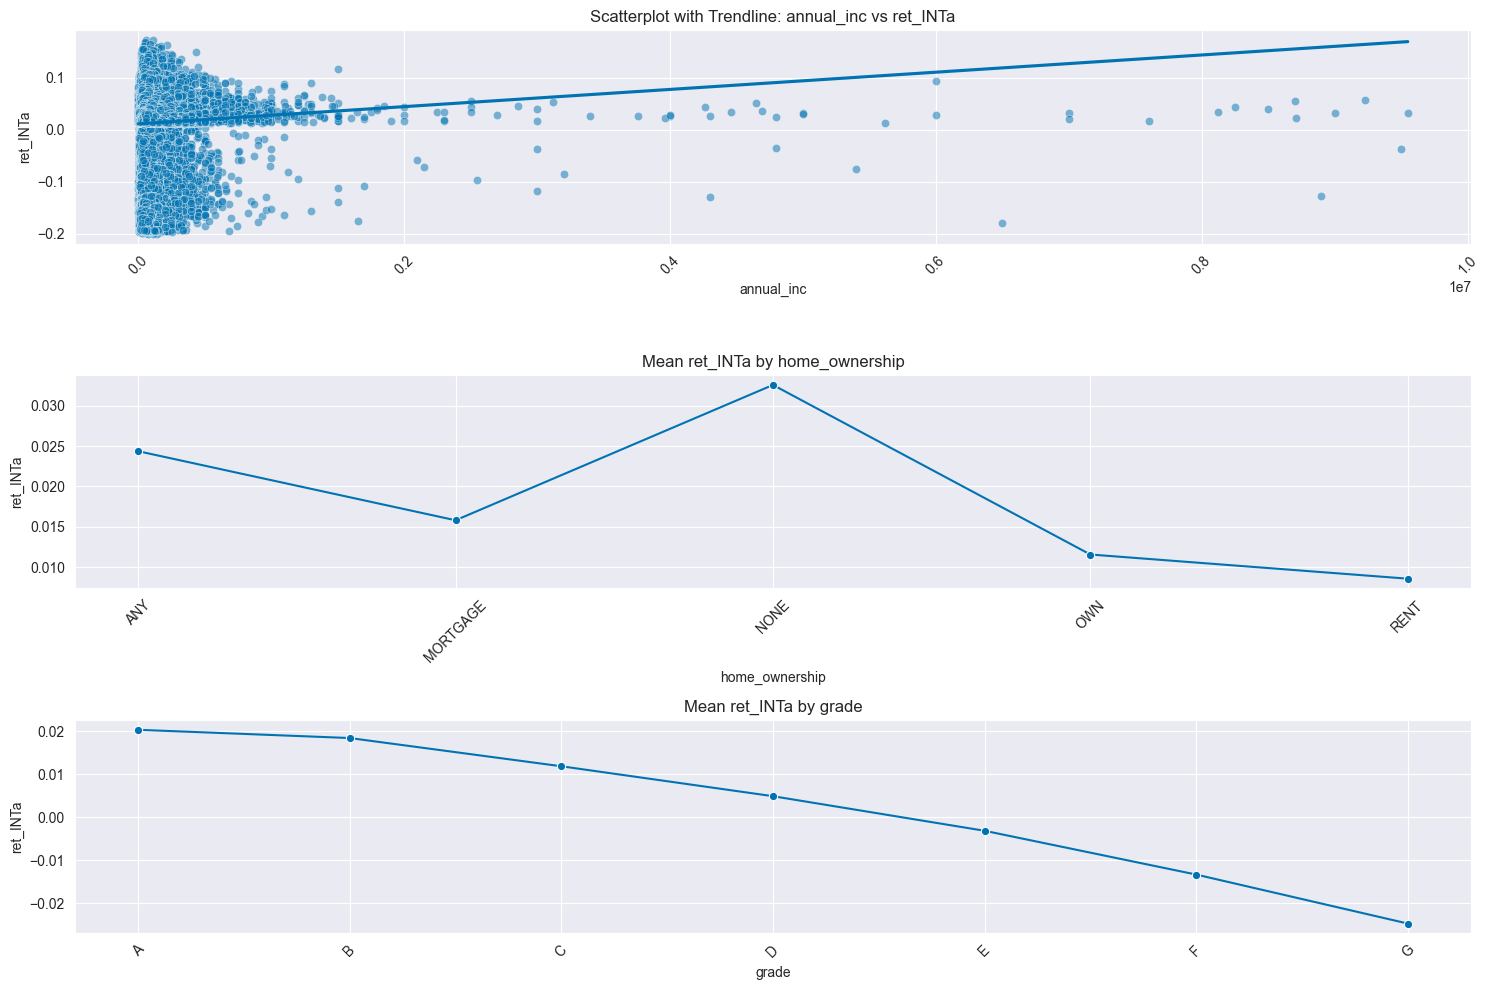

In [36]:
fig, axs = plt.subplots(3, 1, figsize=(15, 10))
plt.sca(axs[0])
eda.plot_relationship_continuous(x="annual_inc", y="ret_INTa", subplot=True)
plt.sca(axs[1])
eda.plot_line_discrete_continuous(x_discrete="home_ownership", y_continuous="ret_INTa", subplot=True)
plt.sca(axs[2])
eda.plot_line_discrete_continuous(x_discrete="grade", y_continuous="ret_INTa", subplot=True)
plt.tight_layout()
plt.show()

<div style="line-height: 1.6;">
Annual income and grade interact with return as expected, we see a higher return as income rises and lower return as grade decreases. We don't see a clear relationship between home ownership and return, although mortgage holders seeing greater return than those that are renting can be justified conceptually.
</div>
<br>
<div style="line-height: 1.6;">
Finally, we plot correlations across all features to identify any features that may cause leakage or features that may be redundant (i.e., high correlation with another feature would mean only one of those features would be useful to the model).
</div>

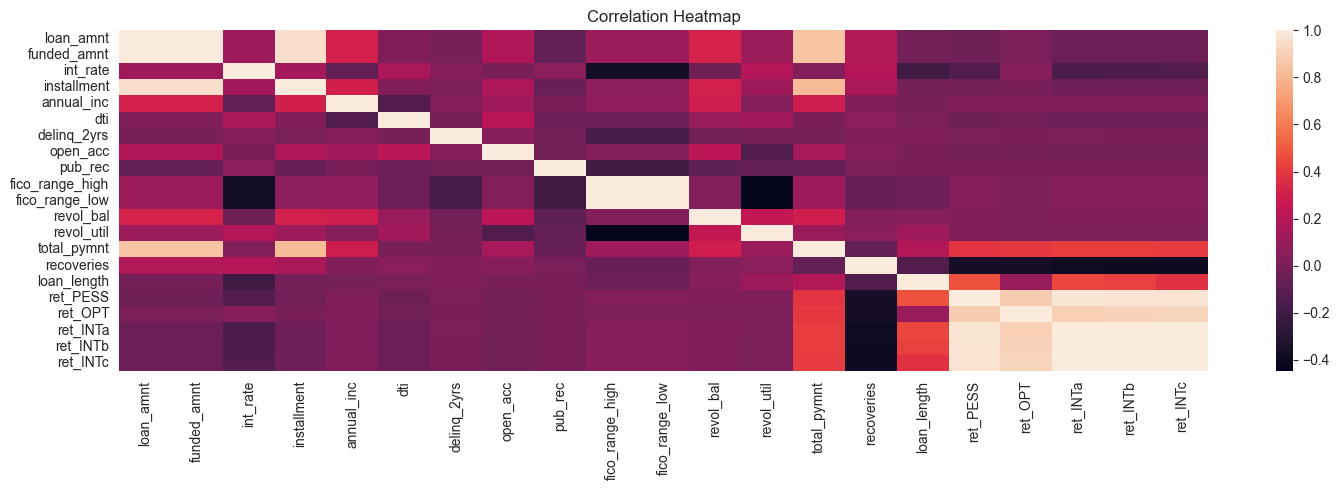

In [43]:
eda.plot_heatmap()

<div style="line-height: 1.6;">
The heatmap above shows us correlations between the continuous variables in the dataset. After using the above and anaysing the conceptual definitions of all the features in the dataset, we identified the below as features that may cause data leakage or were redundant and will need to be removed prior to modelling. 
<div style="padding-left: 20px;"> 
<ol>
    <li>'id': does not provide the model with any useful information.</li>
    <li>'issue_d', 'last_pymnt_d', 'earliest_cr_line' (date columns): as these would classify as categorical columns, the high cardinality of these features would reduce their usefulness. Instead of using these features as is, we compute a feature called 'credit_history_months' to depict the length of the customer's credit history in months.</li>
    <li>'ret_PESS', 'ret_OPT', 'ret_INTa', 'ret_INTb', 'ret_INTc' (return columns): As these were likely computed after the loan had reached maturity or had defaulted, they classify as 'leaky' feaures.</li>
    <li>'total_pymnt', 'recoveries': Both features are also only available after loan has matured and will cause data leakage.</li>
    <li>'term', 'funded_amnt': These are both redundant features. They are highly correlated with 'term_num' and 'loan_amnt' respectively and therefore add no usefu information to the model.</li>
</ol>
    </div>
</div>

## Investment Strategy 1: Maximising Return

###  Model 1

### Model 2

## Investment Strategy 2: Minimising Default

###  Model 1

### Model 2

## Experiments & Results

## Conclusions

## Acknowledgements

## References

## Appendices

### Library Imports

In [34]:
from pydantic import BaseModel, ConfigDict, Field
from typing import Optional, List, Dict, Any

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### Data Exploration Code

In [3]:
# Set plot styles
sns.set_style("darkgrid")
sns.set_palette("colorblind")

In [35]:
# load data
data, discrete_features, continuous_features = pd.read_pickle("lending_club_dataset.pickle")
data['loan_status_binary'] = data['loan_status'].apply(lambda x: 1 if x in ['Default', 'Charged Off'] else 0)

# get discrete and cont features (lists provided as part of pickle are incomplete)
disc = []
cont = []

for col in data.select_dtypes(include=['number', 'object', 'category']).columns:
    unique_vals = data[col].nunique(dropna=True)
    dtype = data[col].dtype

    if pd.api.types.is_numeric_dtype(dtype):
        if unique_vals <= 5:
            disc.append(col)
        else:
            cont.append(col)
    else:
        disc.append(col)

In [9]:
## Grade-level df

# Percentage of loans by grade
perc_by_grade = (data.grade.value_counts() * 100 / len(data)).sort_index()

# Average interest rate and ret_INTa by grade
int_rate_by_grade = data.groupby("grade").apply(lambda x: np.mean(x.int_rate))
ret_by_grade_OPT = data.groupby("grade").apply(lambda x: np.mean(x.ret_INTa) * 100)

# Percentage of defaulted loans by grade
default_by_grade = data.groupby("grade").apply(lambda x: (x.loan_status.isin(["Charged Off", "Default"]).sum() * 100 / len(x)))

# Combine into one DataFrame
grades_df = pd.DataFrame(perc_by_grade)
grades_df.columns = ['% of Loans']
grades_df['int_rate'] = int_rate_by_grade
grades_df['ret_OPT'] = ret_by_grade_OPT
grades_df['default_%'] = default_by_grade


/var/folders/sq/dsmjj4353bg3dvwgbffm9lmh0000gn/T/ipykernel_35919/1557242009.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  int_rate_by_grade = data.groupby("grade").apply(lambda x: np.mean(x.int_rate))
/var/folders/sq/dsmjj4353bg3dvwgbffm9lmh0000gn/T/ipykernel_35919/1557242009.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ret_by_grade_OPT = data.groupby("grade").apply(lambda x: np.mean(x.ret_INTa

In [11]:
## Grade-level df

# Percentage of loans by grade
perc_by_grade = (data.grade.value_counts() * 100 / len(data)).sort_index()

# Average interest rate and ret_INTa by grade
int_rate_by_grade = data.groupby("grade").apply(lambda x: np.mean(x.int_rate))
ret_by_grade_OPT = data.groupby("grade").apply(lambda x: np.mean(x.ret_INTa) * 100)

# Percentage of defaulted loans by grade
default_by_grade = data.groupby("grade").apply(lambda x: (x.loan_status.isin(["Charged Off", "Default"]).sum() * 100 / len(x)))

# Combine into one DataFrame
grades_df = pd.DataFrame(perc_by_grade)
grades_df.columns = ['% of Loans']
grades_df['int_rate'] = int_rate_by_grade
grades_df['ret_INTa'] = ret_by_grade_OPT
grades_df['default_%'] = default_by_grade


/var/folders/sq/dsmjj4353bg3dvwgbffm9lmh0000gn/T/ipykernel_35919/2717647831.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  int_rate_by_grade = data.groupby("grade").apply(lambda x: np.mean(x.int_rate))
/var/folders/sq/dsmjj4353bg3dvwgbffm9lmh0000gn/T/ipykernel_35919/2717647831.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ret_by_grade_OPT = data.groupby("grade").apply(lambda x: np.mean(x.ret_INTa

In [21]:
## Home ownership-level df

# Percentage of loans by grade
perc_by_own = (data.home_ownership.value_counts() * 100 / len(data)).sort_index()

# Average interest rate and ret_INTa by grade
int_rate_by_own = data.groupby("home_ownership").apply(lambda x: np.mean(x.int_rate))
ret_by_grade_own = data.groupby("home_ownership").apply(lambda x: np.mean(x.ret_INTa) * 100)

# Percentage of defaulted loans by grade
default_by_own = data.groupby("home_ownership").apply(lambda x: (x.loan_status.isin(["Charged Off", "Default"]).sum() * 100 / len(x)))

# Combine into one DataFrame
ownership_df = pd.DataFrame(perc_by_own)
ownership_df.columns = ['% of Loans']
ownership_df['int_rate'] = int_rate_by_own
ownership_df['ret_INTa'] = ret_by_grade_own
ownership_df['default_%'] = default_by_own

/var/folders/sq/dsmjj4353bg3dvwgbffm9lmh0000gn/T/ipykernel_35919/731480348.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  int_rate_by_own = data.groupby("home_ownership").apply(lambda x: np.mean(x.int_rate))
/var/folders/sq/dsmjj4353bg3dvwgbffm9lmh0000gn/T/ipykernel_35919/731480348.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ret_by_grade_own = data.groupby("home_ownership").apply(lambda x: np.m

In [42]:
class DataProfile(BaseModel):
    df: pd.DataFrame
    continuous_features: List[str] = Field(default=cont, description="list of continuous features")
    discrete_features: List[str] = Field(default=disc, description="list of discrete features")
    
    model_config = ConfigDict(arbitrary_types_allowed=True)
    
    def plot_distribution(self, feature: str, figsize=(15, 5), subplot=False):
        if not subplot:
            plt.figure(figsize=figsize)
        plt.title(f"Distribution of {feature}")
        
        if feature in self.continuous_features:
            sns.kdeplot(self.df[feature])
            plt.ylabel("Density")
        else:
            ax = sns.histplot(self.df[feature].dropna(), kde=True, bins=30)
            ax.bar_label(ax.containers[0], fmt='%d', label_type='edge', fontsize=9)
            plt.ylabel("Frequency")
        
        if not subplot:
            plt.tight_layout()
            plt.show()

    def plot_comparative_dist(self, feature1: str, feature2: str, plot_type: str = "kde", figsize=(15, 5), subplot=False):
        if plot_type == "kde":
            if any([feature in self.discrete_features for feature in [feature1, feature2]]):
                return "TypeError: KDE cannot be created using discrete features."
            if not subplot:
                plt.figure(figsize=figsize)
            sns.kdeplot(self.df[feature1].dropna(), label=feature1, fill=True, alpha=0.4)
            sns.kdeplot(self.df[feature2].dropna(), label=feature2, alpha=0.4)
            plt.title(f'KDE Comparison: {feature1} vs {feature2}')
            plt.xlabel('Value')
            plt.ylabel('Density')
            plt.legend()

        if plot_type == "boxplot":
            if not subplot:
                plt.figure(figsize=figsize)
            sns.boxplot(data=self.df[[feature1, feature2]])
            plt.title(f'Boxplot Comparison: {feature1} vs {feature2}')
        
        if not subplot:
            plt.tight_layout()
            plt.show()

    def plot_relationship_continuous(self, x: str, y: str, figsize=(15, 5), subplot=False):
        if not subplot:
            plt.figure(figsize=figsize)
        if pd.api.types.is_numeric_dtype(self.df[x]) and pd.api.types.is_numeric_dtype(self.df[y]):
            sns.scatterplot(data=self.df, x=x, y=y, alpha=0.5)
            sns.regplot(data=self.df, x=x, y=y, scatter=False, ci=None)
            plt.title(f'Scatterplot with Trendline: {x} vs {y}')
        else:
            print("TypeError: Invalid data types. Please check that both features are continuous.")
        plt.xticks(rotation=45)
        if not subplot:
            plt.tight_layout()
            plt.show()

    def plot_relationship_discrete(self, x: str, y: str, figsize=(15, 5), subplot=False):
        if not subplot:
            plt.figure(figsize=figsize)
        sns.countplot(data=self.df, x=x, hue=y)
        plt.title(f'Countplot: {x} vs {y}')
        plt.xticks(rotation=45)
        if not subplot:
            plt.tight_layout()
            plt.show()

    def plot_line_discrete_continuous(self, x_discrete, y_continuous, aggfunc='mean', figsize=(15, 5), subplot=False):
        grouped = self.df.groupby(x_discrete)[y_continuous].agg(aggfunc).reset_index()
        if pd.api.types.is_object_dtype(self.df[x_discrete]) or pd.api.types.is_categorical_dtype(self.df[x_discrete]):
            grouped = grouped.sort_values(by=x_discrete)
        if not subplot:
            plt.figure(figsize=figsize)
        sns.lineplot(data=grouped, x=x_discrete, y=y_continuous, marker='o')
        plt.title(f'{aggfunc.title()} {y_continuous} by {x_discrete}')
        plt.xticks(rotation=45)
        if not subplot:
            plt.tight_layout()
            plt.show()
    
    def bar_plot_by_index(self, y: str, figsize=(15, 5), title="", subplot=False):
        if not subplot:
            plt.figure(figsize=figsize)
        sns.barplot(x=self.df.index, y=self.df[y])
        plt.title(title)
        plt.xticks(rotation=45)
        if not subplot:
            plt.tight_layout()
            plt.show()

    def plot_heatmap(self, figsize=(15, 5), subplot=False):
        if not subplot:
            plt.figure(figsize=figsize)
        plt.title("Correlation Heatmap")
        plt.xticks(rotation=45)
        sns.heatmap(self.df[self.continuous_features].corr(), annot=False)
        if not subplot:
            plt.tight_layout()
            plt.show()

# create instance of class
eda = DataProfile(df=data)
eda_grade = DataProfile(df=grades_df)
eda_own = DataProfile(df=ownership_df)

In [ ]:
### 

### Investment Strategy 1 (Return-based)